In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from pytil.object import Namespace as O
from pytil.utility import *
#from helpers import *

import random, math, functools, itertools, os

ss = slice(None)

In [2]:
df = pd.read_hdf('../data/train.hdf5')
dg = pd.read_hdf('../data/test.hdf5')
dh = pd.concat([df, dg])
dh['Index'] = dh.index
dh['Count'] = 1
dh['wy'] = dh.Weight * dh.y
df, dg = dh.loc[:-1], dh.loc[0:]

In [3]:
N_TRAIN, N_TEST = 623817, 640430
n_stock = len(set(dh.Stock))

In [4]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()
idfeats = 'Market Stock'.split()

# EDA plots

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from altair import *
sns.set()
from pytil.quickvis import canvas
canvas(16, 12)

In [7]:
from pytil.algorithm import count_inversions
count_inversions(list(df[df.Day == 21].Stock))

1472723

In [8]:
for m in range(1, 4 + 1):
    print(dh[dh.Market == m].Stock.agg(['min', 'max']))

min      10
max    3020
Name: Stock, dtype: int64
min       0
max    2995
Name: Stock, dtype: int64
min       4
max    3022
Name: Stock, dtype: int64
min       3
max    3021
Name: Stock, dtype: int64


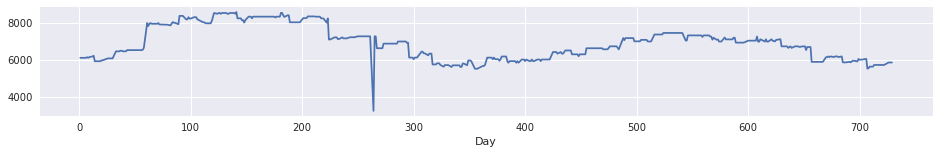

In [45]:
C = O(MARKET=1)
data = dh[dh.Market == C.MARKET]
data = data.groupby('Day').Stock.agg(lambda x: count_inversions(list(x)))
data.plot();

In [7]:
dh['DailyIndex'] = dh.groupby(['Market', 'Day']).Index.rank().astype(int) - 1

```apl
y <-> feature pairs
    y(color) weight(size) {day, [stock,] x...}pairs
Weigh
```

In [104]:
from statsmodels.stats.weightstats import DescrStatsW
def Weighted(method, nan_placeholder=None):
    def weighted_method(a):
        val = DescrStatsW(a.drop('Weight', axis=1), weights=a.Weight, ddof=a.Weight.mean()).__getattribute__(method)
        val = np.float64(val[0]) #pd.Series(val, a.drop('Weight', axis=1).columns)
        if not np.isfinite(val):
            if nan_placeholder is None:
                raise ValueError('NaN in computation but nan_placeholder not set')
        return val if np.isfinite(val) else nan_placeholder
    return weighted_method

/home/ec2-user/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:179: RuntimeWarning: divide by zero encountered in true_divide
  return self.sumsquares / (self.sum_weights - self.ddof)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:179: RuntimeWarning: invalid value encountered in true_divide
  return self.sumsquares / (self.sum_weights - self.ddof)


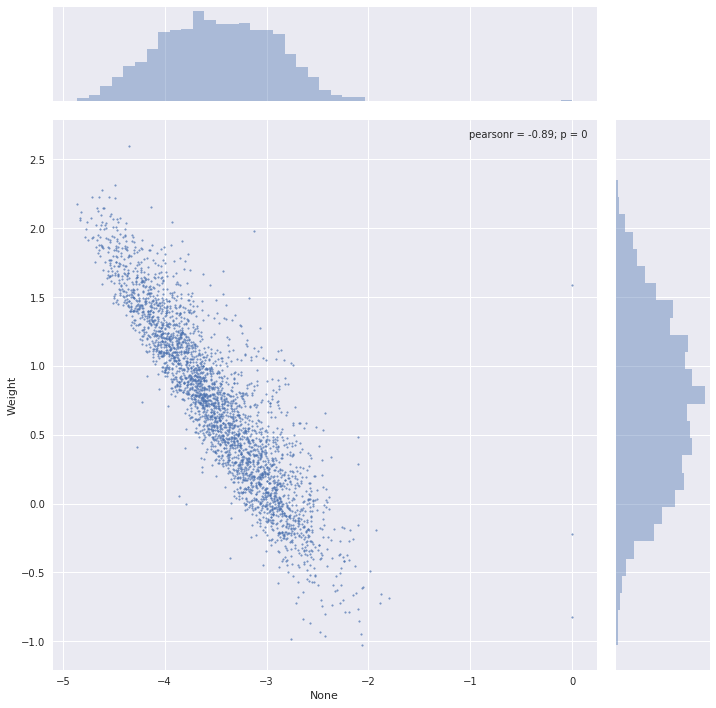

In [105]:
data = df#[df.Market == 3]
weight_mean = data.groupby('Stock').Weight.mean()
y_std = data.groupby('Stock')[['y', 'Weight']].apply(Weighted('std', nan_placeholder=1))
sns.jointplot(np.log10(y_std), np.log10(weight_mean), s=3, alpha=.7, size=10);

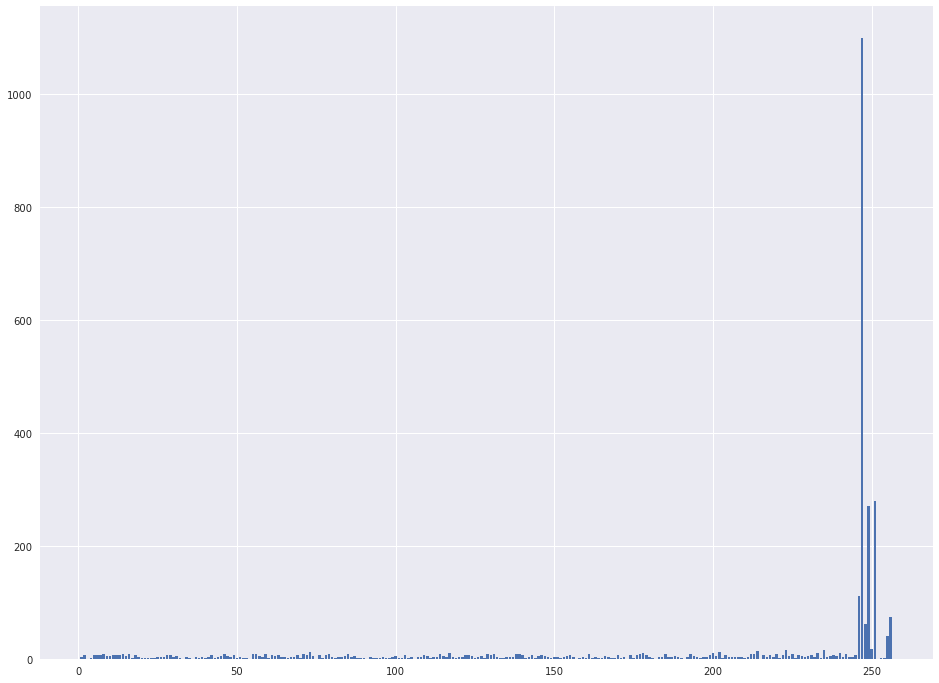

In [44]:
data = df.groupby('Stock').count().Count.value_counts(dropna=False)
plt.bar(data.index, data.values);

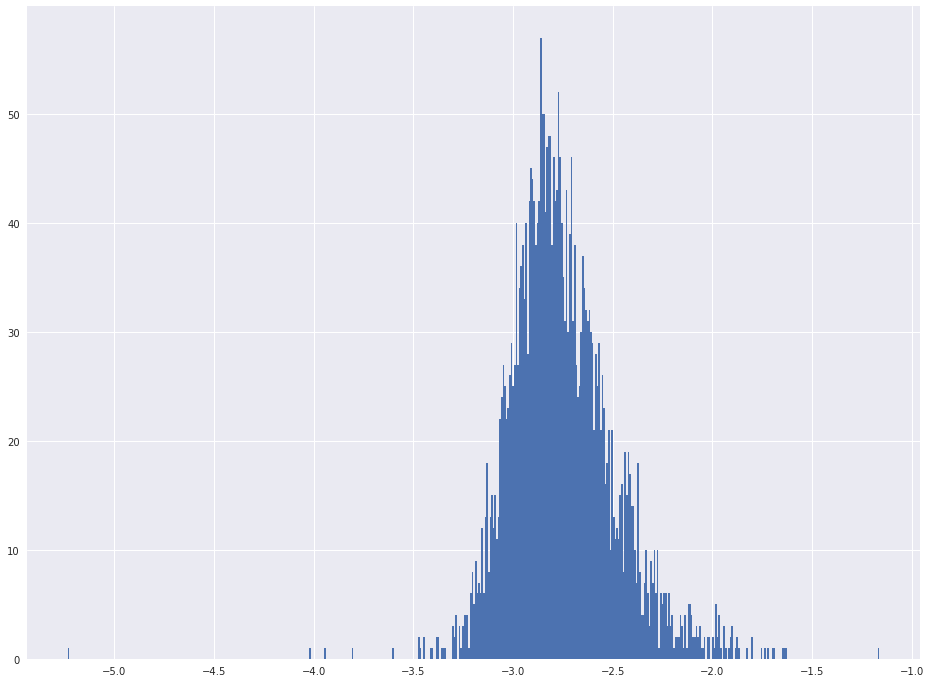

In [48]:
data = df.groupby('Stock').wy.agg(lambda x: x.std())
np.log10(data).hist(bins=500);

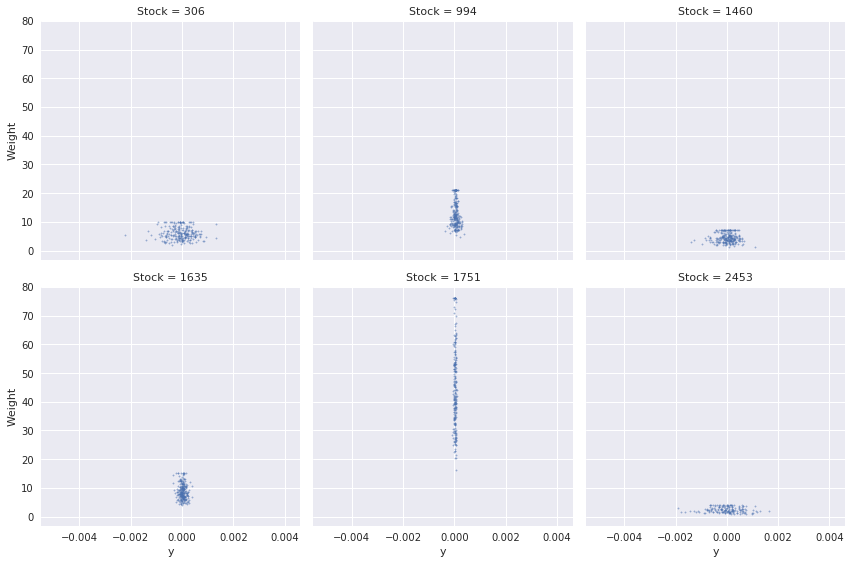

In [354]:
#C = O(MARKET=4, N_SAMPLES=20, COL_WRAP=5, HEIGHT=135, WIDTH=135)
C = O(MARKET=3, N_SAMPLES=6, COL_WRAP=3, HEIGHT=235, WIDTH=235)
data = df[df.Market == C.MARKET]
C.STOCKS = random.sample(set(data.Stock), C.N_SAMPLES)
data = data[data.Stock.isin(STOCKS)].copy()
C.EXT = data.y.abs().max()
g = sns.FacetGrid(data, col='Stock', col_wrap=C.COL_WRAP, size=4)
g = g.map(plt.scatter, 'y', 'Weight', s=2, alpha=.5)

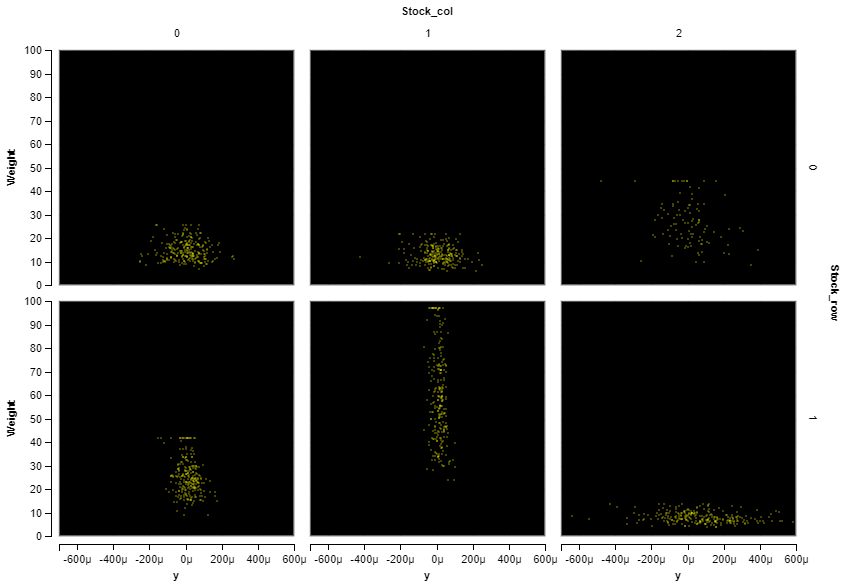

In [360]:
#C = O(MARKET=4, N_SAMPLES=20, COL_WRAP=5, HEIGHT=135, WIDTH=135)
C = O(MARKET=3, N_SAMPLES=6, COL_WRAP=3, HEIGHT=235, WIDTH=235)
data = df[df.Market == C.MARKET]
C.STOCKS = random.sample(set(data.Stock), C.N_SAMPLES)
data = data[data.Stock.isin(C.STOCKS)].copy()
data['Stock_idx'] = data.Stock.map(lambda x: C.STOCKS.index(x))
data['Stock_row'] = data.Stock_idx // C.COL_WRAP
data['Stock_col'] = data.Stock_idx % C.COL_WRAP
#data.Weight /= 10000
#data.Count = 1
#data.y *= 1000
C.EXT = data.y.abs().max()
Chart(data).mark_circle(opacity=.7, size=1, shape='circle', color='yellow').encode(
    column = 'Stock_col',
    row = 'Stock_row',
    x = X('y', scale=Scale(type='linear')),
    y = Y('Weight', scale=Scale(type='linear')),
    #size = Size('Weight', scale=Scale(type='log')),
    #color = Color('y', scale=Scale(domain=[-C.EXT, 0, C.EXT], range=['blue', '#dddddd', 'red'])),
).configure_cell(
    height = C.HEIGHT,
    width = C.WIDTH,
    fill = 'black',
)

In [225]:
Scale?

In [ ]:
# stock encoding ideas
- number of days available for a stock
- average of Day for stock
    - whether stock data was available (at least 1/2 the time) for some time periods
- deviation from average daily index

# x interactions ideas
- x on y / y on x linear regression residuals (log-log)
- PCA on log-log plot

# model ideas
- train XGBoost with different weight patterns (e.g. normalize weights across different stocks)
    to let avoid differing error patterns
- cluster days by PCA and determine closest day cluster for days

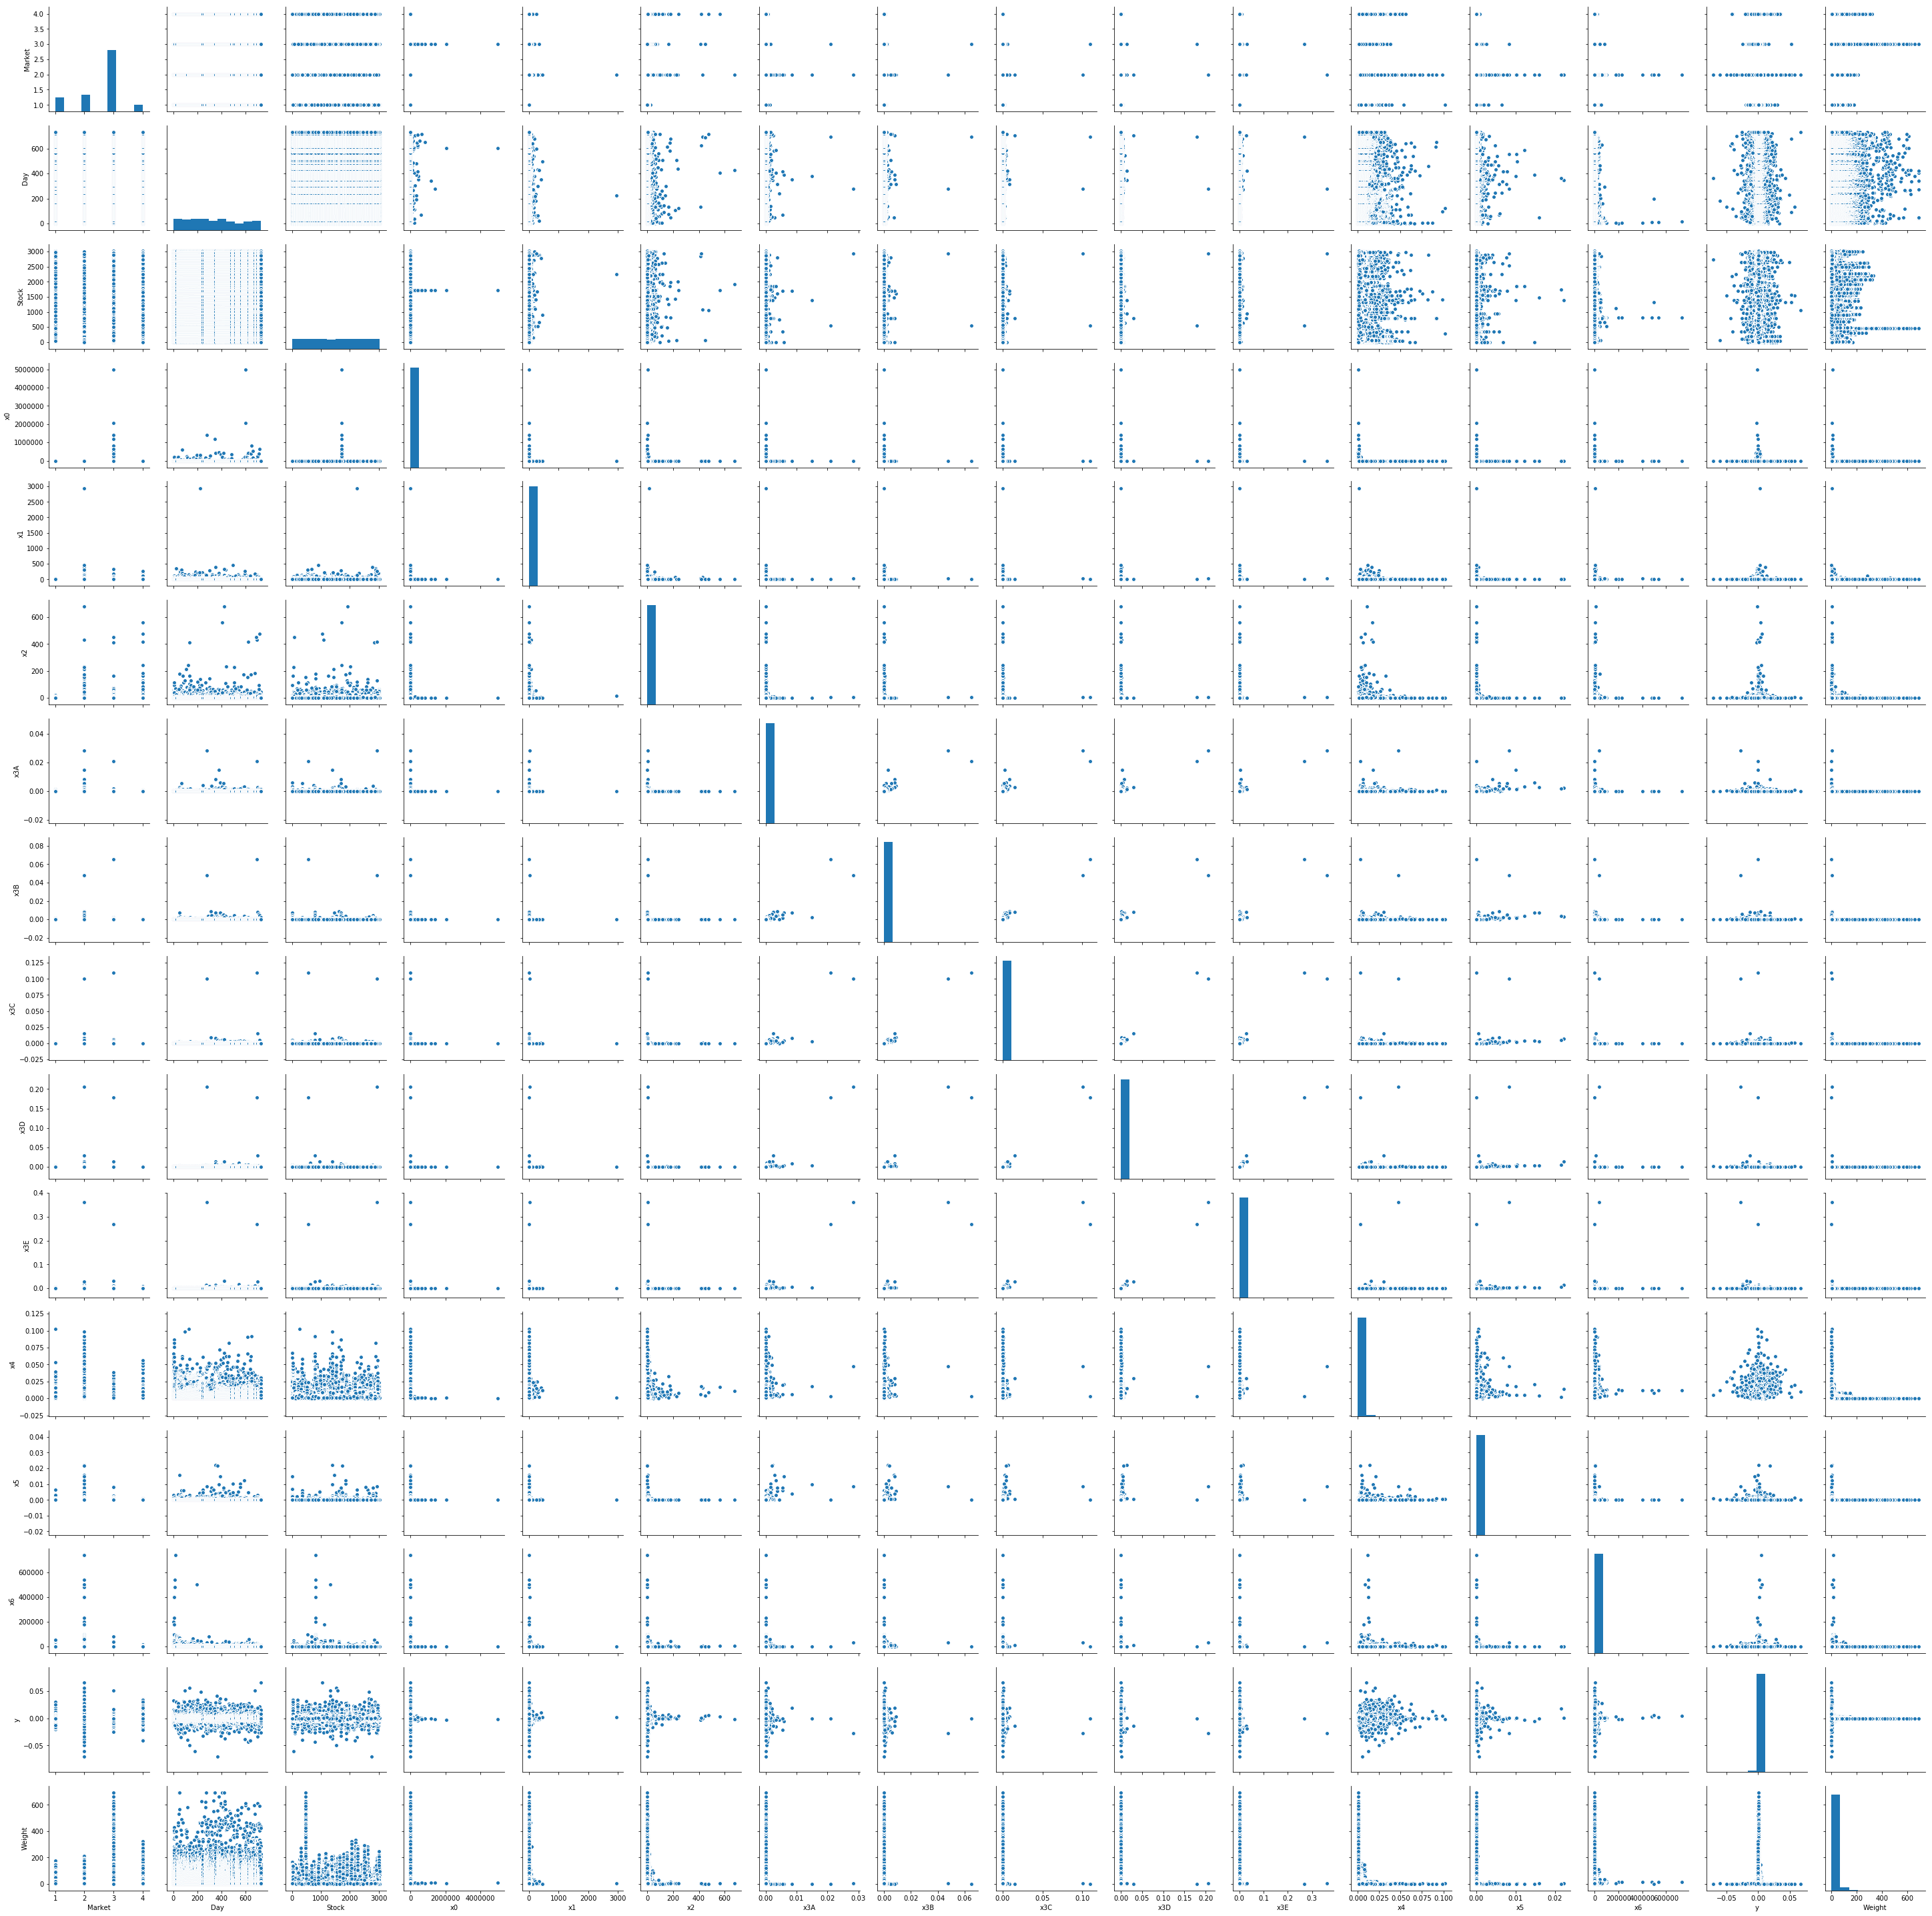

In [5]:
sns.pairplot(df.dropna())